# Проект: Прогнозирование заказов такси

__Заказчик__: компания «Чётенькое такси».

__Цель проекта__: разработка модели для прогнозирования количества заказов такси на следующий час. Это позволит заказчику привлекать больше водителей в период пиковой нагрузки.

__Описание данных__: исторические данные о заказах такси в аэропортах.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

__Горизонт прогнозирования__: 1 час.

__Оценка модели__:
- Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

__План выполнения__:
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Распределение-значений" data-toc-modified-id="Распределение-значений-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Распределение значений</a></span></li><li><span><a href="#Число-заказов-с-течением-времени" data-toc-modified-id="Число-заказов-с-течением-времени-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Число заказов с течением времени</a></span></li><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Создание-моделей" data-toc-modified-id="Создание-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Создание моделей</a></span><ul class="toc-item"><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Предсказание-константой" data-toc-modified-id="Предсказание-константой-3.2.5"><span class="toc-item-num">3.2.5&nbsp;&nbsp;</span>Предсказание константой</a></span></li><li><span><a href="#Предсказание-предыдущим-значением" data-toc-modified-id="Предсказание-предыдущим-значением-3.2.6"><span class="toc-item-num">3.2.6&nbsp;&nbsp;</span>Предсказание предыдущим значением</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

# константы
RANDOM_STATE = 42

In [ ]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, расположены ли даты и время в хронологическом порядке, всегда ли между записями 10 минут.

In [6]:
data.index.is_monotonic

True

In [7]:
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

In [8]:
full_time_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='10min')

# Сравниваем временной диапазон с индексом данных
missing_times = full_time_range.difference(data.index)

if len(missing_times) == 0:
    print("Данные равномерны, пропусков нет.")
else:
    print(f"Обнаружены пропуски.")

Данные равномерны, пропусков нет.


Данные собраны за период с 01-03-2018 по 31-08-2018 за каждые 10 минут. Выполним ресемплирование по 1 часу.

In [9]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
data.shape

(4416, 1)

__Промежуточный вывод__:
- загрузили данные, всего 26496 записей,
- пропусков нет, название столбца записано в змеином стиле,
- данные соответствуют описанию и представляют собой временной ряд, при загрузке сразу установили столбец `Datetime` как индекс таблицы и преобразовали его в datetime,
- данные расположены в хронологическом порядке, представлен период с 01-03-2018 по 31-08-2018 за каждые 10 минут,
- выполнили ресемплирование по 1 часу, итоговое количество записей - 4416.

## Анализ

### Распределение значений

Для начала посмотрим на распределение значений.

In [11]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


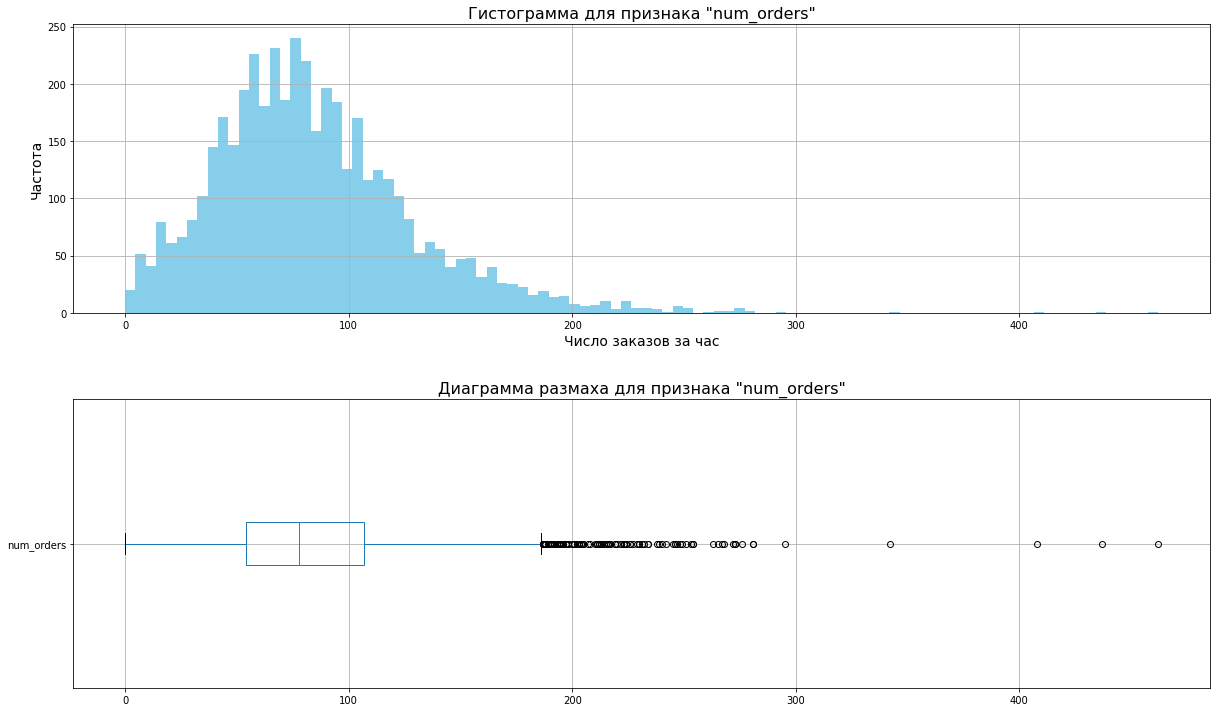

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(17, 10))
ax[0].hist(data['num_orders'], color='skyblue', bins=100)
ax[0].set_title(f'Гистограмма для признака "num_orders"', fontsize=16)
ax[0].set_xlabel('Число заказов за час', fontsize=14)
ax[0].set_ylabel('Частота', fontsize=14)
ax[0].grid(True)

# Диаграмма размаха
ax[1] = data[['num_orders']].boxplot(vert=False, ax=ax[1])
ax[1].set_title(f'Диаграмма размаха для признака "num_orders"', fontsize=16)
    
plt.tight_layout()
# Установка вертикального отступа между графиками
plt.subplots_adjust(hspace=0.3)
plt.show()

Число заказов за час находится в диапазоне от 0 до 462, межквартильный размах - от 54 до 107, некоторые значения определены как выбросы. Нетипичное количество заказов может быть связано с какими-либо отдельными событиями (например, отмена или перенос рейсов).

### Число заказов с течением времени

Теперь изучим, как изменяется число заказов с течением времени.

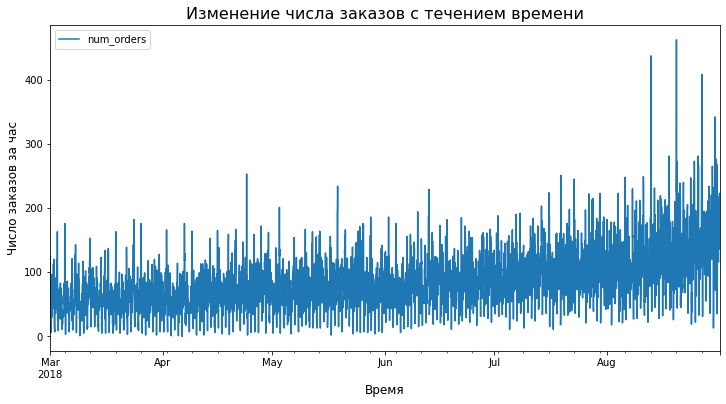

In [13]:
data.plot(figsize=(12, 6))
plt.title('Изменение числа заказов с течением времени', fontsize=16)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Число заказов за час', fontsize=12)
plt.show()

### Скользящее среднее

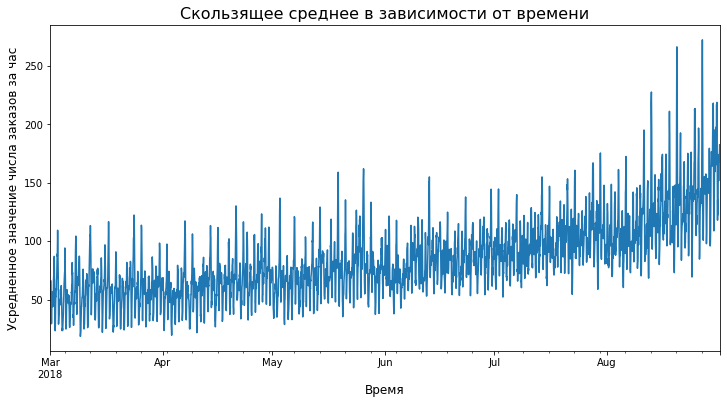

In [14]:
data.rolling(6).mean().plot(figsize=(12, 6), legend=False)
plt.title('Скользящее среднее в зависимости от времени', fontsize=16)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Усредненное значение числа заказов за час', fontsize=12)
plt.show()

Видим, что среднее значение со временем растет. 

### Тренды и сезонность

Разложим временной ряд на три составляющие: тренд, сезонность и остаток.

In [15]:
decomposed = seasonal_decompose(data)

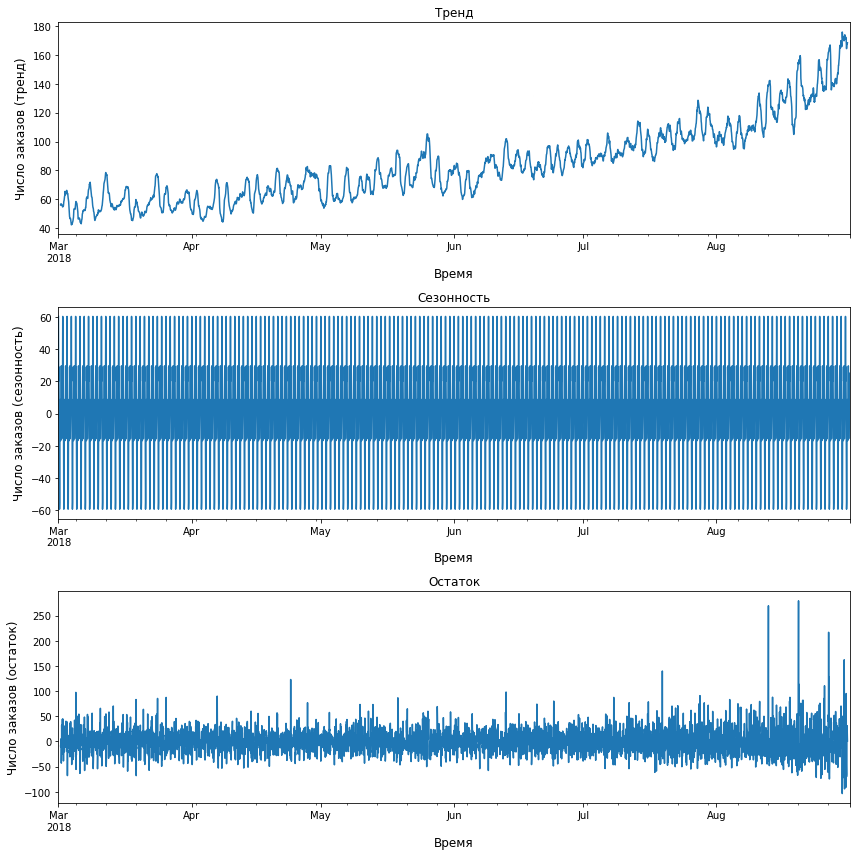

In [16]:
plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.ylabel('Число заказов (тренд)', fontsize=12)
plt.xlabel('Время', fontsize=12)
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.ylabel('Число заказов (сезонность)', fontsize=12)
plt.xlabel('Время', fontsize=12)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.ylabel('Число заказов (остаток)', fontsize=12)
plt.xlabel('Время', fontsize=12)
plt.tight_layout()

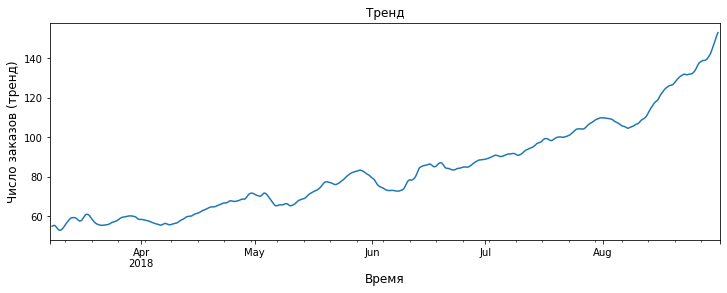

In [17]:
# используем скользящее среднее за неделю и посмотрим на тренд
plt.figure(figsize=(12, 4))
seasonal_decompose(data.rolling(24*7).mean().dropna()).trend.plot()
plt.title('Тренд')
plt.ylabel('Число заказов (тренд)', fontsize=12)
plt.xlabel('Время', fontsize=12)
plt.show()

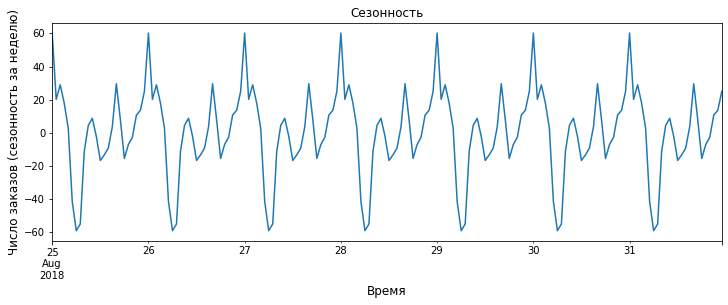

In [18]:
# посмотрим на данные за последнюю неделю
plt.figure(figsize=(12, 4))
decomposed.seasonal['2018-08-25':'2018-08-31'].plot()
plt.title('Сезонность')
plt.ylabel('Число заказов (сезонность за неделю)', fontsize=12)
plt.xlabel('Время', fontsize=12)
plt.show()

__Промежуточный вывод:__

Видим долгосрочную тенденцию - рост числа заказов. Также прослеживается сезонность в течение суток: число заказов начинает расти с утра и до полуночи, наблюдаются три пика, после полуночи снижается.

## Обучение

### Создание признаков

Перед обучением создадим несколько новых признаков.

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    """
    Функция создает новые признаки на основе временного ряда.

    Args:
        data (pd.DataFrame): Исходный датафрейм с временным рядом. 
        max_lag (int): Максимальное количество лагов (сдвигов) для создания признаков.
        rolling_mean_size (int): Размер окна для вычисления скользящего среднего.

    Returns:
        DataFrame: Новый датафрейм с добавленными признаками:
                      - 'month': месяц из даты.
                      - 'day': день месяца из даты.
                      - 'dayofweek': день недели.
                      - 'hour': час из даты.
                      - 'lag_{n}': сдвиги целевой переменной 'num_orders' на n шагов назад.
                      - 'rolling_mean': скользящее среднее целевой переменной 'num_orders'.
    """
    df = data.copy()
    df['month'] = data.index.month
    df['day'] = data.index.day
    df['dayofweek'] = data.index.dayofweek
    df['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    df['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

new_data = make_features(data, 4, 4)
new_data.shape

(4416, 10)

### Создание моделей

In [20]:
results = pd.DataFrame(columns=['model', 'params', 'training_time', 'RMSE'])

In [21]:
train, test = train_test_split(new_data, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [22]:
tscv = TimeSeriesSplit(n_splits=5)

In [23]:
def train_and_evaluate(model, params, X_train, y_train):
    """
    Функция для поиска лучших гиперпараметров для модели с использованием GridSearchCV.

    Args:
        model: Модель.
        params (dict): Словарь с параметрами для поиска. 
        X_train (DataFrame): Обучающие данные.
        y_train (Series): Целевая переменная.

    Returns:
        grid_search: Объект GridSearchCV с лучшей моделью.
        search_time (float): Время, затраченное на поиск лучших параметров (в секундах).
    """
    start = time.time()
    grid_search = GridSearchCV(model,
                               params,
                               cv=tscv,
                               scoring='neg_root_mean_squared_error')
    grid_search.fit(X_train, y_train)
    search_time = time.time() - start

    print('Параметры лучшей модели:\n', grid_search.best_params_)
    print ('Метрика лучшей модели при кросс-валидации:', grid_search.best_score_)
    print ('Время поиска лучших параметров:', search_time, 'секунд')
    
    return grid_search, search_time

#### CatBoostRegressor

In [24]:
param_catboost = {
    'iterations': [200, 600],  
    'depth': [4, 8]
}

grid_search_cb, training_time_cb = train_and_evaluate(
    CatBoostRegressor(random_state=RANDOM_STATE, verbose=0),
    param_catboost,
    X_train, y_train) 

results.loc[0] = ['CatBoostRegressor', grid_search_cb.best_params_,
                   training_time_cb, -grid_search_cb.best_score_]

Параметры лучшей модели:
 {'depth': 4, 'iterations': 600}
Метрика лучшей модели при кросс-валидации: -25.391466691613623
Время поиска лучших параметров: 33.508893966674805 секунд


#### RandomForestRegressor

In [25]:
param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [8, 10, 15],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf, training_time_rf = train_and_evaluate(
    RandomForestRegressor(random_state=RANDOM_STATE),
    param_rf,
    X_train, y_train) 

results.loc[1] = ['RandomForestRegressor', grid_search_rf.best_params_, 
                  training_time_rf, -grid_search_rf.best_score_]

Параметры лучшей модели:
 {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}
Метрика лучшей модели при кросс-валидации: -25.457831124356318
Время поиска лучших параметров: 88.18239903450012 секунд


#### DecisionTreeRegressor

In [26]:
param_dt = {
    'max_depth': [7, 10, 15], 
    'min_samples_split': [5, 10, 15]
}

grid_search_dt, training_time_dt = train_and_evaluate(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_dt,
    X_train, y_train) 

results.loc[2] = ['DecisionTreeRegressor', grid_search_dt.best_params_,
                   training_time_dt, -grid_search_dt.best_score_]

Параметры лучшей модели:
 {'max_depth': 10, 'min_samples_split': 15}
Метрика лучшей модели при кросс-валидации: -28.16860480163467
Время поиска лучших параметров: 0.5936975479125977 секунд


####  LinearRegression

In [27]:
grid_search_linear, training_time_linear = train_and_evaluate(
    LinearRegression(),
    {},
    X_train, y_train
)

results.loc[3] = ['LinearRegression', grid_search_linear.best_params_,
                   training_time_linear, -grid_search_linear.best_score_]

Параметры лучшей модели:
 {}
Метрика лучшей модели при кросс-валидации: -31.46524014453133
Время поиска лучших параметров: 0.0448145866394043 секунд


#### Предсказание константой

In [28]:
pred_median = np.ones(y_test.shape) * y_train.median()
rmse_median = np.sqrt(mean_squared_error(y_test, pred_median))
results.loc[4] = ['pred_median', None, None, rmse_median]

#### Предсказание предыдущим значением

In [29]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
rmse_pred_previous = np.sqrt(mean_squared_error(y_test, pred_previous))
results.loc[5] = ['pred_previous', None, None, rmse_pred_previous]

In [30]:
results.sort_values(by='RMSE')

,model,params,training_time,RMSE
0,CatBoostRegressor,"{'depth': 4, 'iterations': 600}",33.508894,25.391467
1,RandomForestRegressor,"{'max_depth': 15, 'min_samples_split': 5, 'n_e...",88.182399,25.457831
2,DecisionTreeRegressor,"{'max_depth': 10, 'min_samples_split': 15}",0.593698,28.168605
3,LinearRegression,{},0.044815,31.465240
5,pred_previous,None,NaN,58.856486
4,pred_median,None,NaN,87.152776


__Промежуточный вывод:__ 

Все модели показали результат, превосходящий предсказание медианой и предыдущим значением. Лучшая модель - CatBoostRegressor с параметрами 'depth': 4, 'iterations': 600, RMSE на кросс-валидации 25.39.

## Тестирование лучшей модели

In [31]:
print(f'RMSE тестовой выборки: {np.sqrt(mean_squared_error(y_test, grid_search_cb.predict(X_test)))}')

RMSE тестовой выборки: 43.39377857945645


__Промежуточный вывод:__

Результат модели на тестовой выборке - 43.39, требование к значению метрики выполнено.

__Вывод:__

Мы изучили исторические данные о заказах такси в аэропортах. Представлен период с 01-03-2018 по 31-08-2018 за каждые 10 минут, выполнили ресемплирование по 1 часу, итоговое количество записей - 4416.

В ходе изучения данных определили долгосрочную тенденцию - рост числа заказов, а также же сезонность в течение суток: число заказов начинает расти с утра и до полуночи, наблюдаются три пика, после полуночи снижается.

Мы добавили новые признаки в датасет: месяц, день месяца, день недели, час, сдвиги целевой переменной на 4 шага назад, скользящее среднее целевой переменной.

Обучили несколько моделей, лучший результат на кросс-валидации показала модель CatBoostRegressor с параметрами 'depth': 4, 'iterations': 600, RMSE на кросс-валидации 25.39. RMSE на тестовой выборке 43.39, что удовлетворяет требованиям заказчика.